In [55]:
from pymongo import MongoClient
from elasticsearch import Elasticsearch, helpers
import requests
from IPython.display import JSON
import numpy as np
from fuzzywuzzy import fuzz
from joblib import Parallel, delayed
import pickle
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

In [12]:
es = Elasticsearch()

In [19]:
# open a file, where you stored the pickled data
file = open('dataset.pkl', 'rb')
# dump information to that file
data = pickle.load(file)
# close the file
file.close()

In [20]:
len(data["p"])

3000

In [21]:
len(data["n"])

3000

In [27]:
p_dois=[]
n_dois=[]
openalex = []
scopus = []
for i in data["p"]:
    p_dois.append(i[0]["DOI"])
    openalex.append(i[1])
    scopus.append(i[0])
for i in data["n"]:
    n_dois.append(i[0]["DOI"])
    openalex.append(i[1])
    scopus.append(i[0])

In [23]:
es_index = "openalex"
recreate = True
if recreate:
    if es.indices.exists(index=es_index):
        es.indices.delete(index=es_index)
if not es.indices.exists(index=es_index):
    es.indices.create(index=es_index)

In [24]:
if recreate:
    request_timeout = 60
    bulk_size = 100

    es_entries = []
    counter = 0
    for i in openalex:
        entry = {"_index": es_index,
                 "_id": counter,
                 "_source": i}
        es_entries.append(entry)
        if len(es_entries) == bulk_size:
            helpers.bulk(es, es_entries, refresh=True,request_timeout=request_timeout)
            es_entries = []
        counter +=1

In [39]:
def get_oa_doi(es_reg):
    for i in es_reg["_source"]['external_ids']:
        if i['source'] == "doi":
            return i["id"]


def get_oa_doi(es_reg):
    return es_reg["_source"]['external_ids']["id"]


In [40]:
def search(Title, Authors, Source, Year, punto_de_corte = 80.0):
    """
    Definir el valor mínimo del _score que deseas
    Puedes ajustar este valor según tus necesidades

    """
    body = {
        "query": {
            "bool": {
                "should": [
                    { "match": { "titles.title":  Title }},
                    { "match": { "authors.full_name": Authors }},
                    { "match": { "source.names.name":  Source}},
                    { "match": { "year_published": Year }}
                ]
            }
        },
        "size": 10
    }
    
    res = es.search(index=es_index, **body)
    hits = []
    
    for i in res["hits"]["hits"]:
        if i["_score"] >= punto_de_corte:
            hits.append(i)
    res["hits"]["hits"] = hits
    return  res

def search_doi(doi, punto_de_corte = 20.0):
    body = {
      "query": {
        "bool": {
          "must": 
            { "match": { "external_ids.id":  doi }}              
        }
      },
      "size": 5,
    }
    res = es.search(index=es_index, **body)
    hits = []
    for i in res["hits"]["hits"]:
        if i["_score"] >= punto_de_corte:
            hits.append(i)
    res["hits"]["hits"] = hits
    return res

In [99]:
%%time
def es_similarity(rec,p,th):
    res = search(rec['Title'],rec['Authors'],rec['Source title'],rec['Year'],th)
    if p:
        if len(res["hits"]["hits"]) > 1:
            oa_doi = get_oa_doi(res["hits"]["hits"][0])
            sc_doi = rec["DOI"]
            if oa_doi == sc_doi and oa_doi in p_dois:
                return True
        return False
    else:
        sc_doi = rec["DOI"]
        res_doi = search_doi(sc_doi)
        if len(res_doi["hits"]["hits"]) == 0:
            True
        return False

th=20
results_p = Parallel(n_jobs=15,backend='threading',verbose=0)(delayed(es_similarity)(rec,True,th) for rec in scopus[0:3000])
results_n = Parallel(n_jobs=15,backend='threading',verbose=0)(delayed(es_similarity)(rec,False,th) for rec in scopus[3000:6000])


CPU times: user 4.61 s, sys: 976 ms, total: 5.59 s
Wall time: 4.71 s


In [100]:
#>tp, tn, fp, fn
actual  = np.concatenate((np.ones(3000, dtype=bool), np.zeros(3000, dtype=bool)))
predicted = np.concatenate((results_p,results_n))

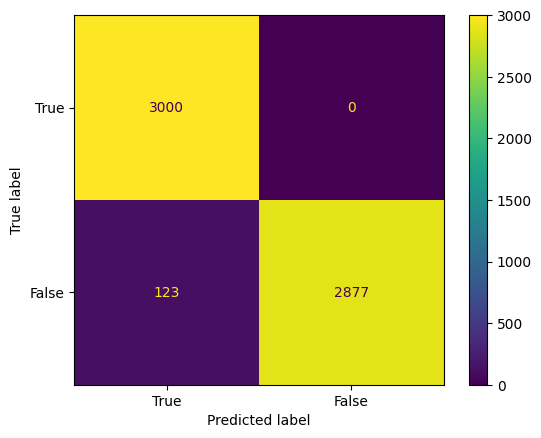

In [101]:
confusion_matrix = metrics.confusion_matrix(actual, predicted)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [True, False])

cm_display.plot()
plt.show()

In [102]:
acc = metrics.accuracy_score(actual,predicted)
pre = metrics.precision_score(actual,predicted)
rec = metrics.recall_score(actual,predicted)

print(f"Accuracy  = {acc}")
print(f"Precision = {pre}")
print(f"Recall    = {rec}")


Accuracy  = 0.9795
Precision = 1.0
Recall    = 0.959


In [83]:
rec = scopus[3001]
print(rec["Title"])
print(rec["DOI"])
res = search(rec['Title'],rec['Authors'],rec['Source title'],rec['Year'],80)
res

Novel technique for the calculation of eddy current losses and Lorentz forces in foil winding transformers
10..3233/JAE-160144


{'took': 2,
 'timed_out': False,
 '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0},
 'hits': {'total': {'value': 5270, 'relation': 'eq'},
  'max_score': 23.00544,
  'hits': []}}

In [ ]:
search_doi(rec["DOI"])


In [34]:
if "10.1001/archderm.134.2.143" in n_dois:
    print("fond")

In [ ]:
res

In [ ]:
print(rec["Title"])
#print(rec["Title"])

oa_doi = get_oa_doi(res["hits"]["hits"][0])
sc_doi = rec["DOI"]
print(oa_doi,sc_doi)
fuzz.token_sort_ratio(oa_doi,sc_doi)


In [ ]:
rec = scopus[0]
print(rec["DOI"])
search_doi(rec["DOI"])

In [ ]:
%%time
count = 0
for rec in scopus[0:1000]:
    res = search(rec['Title'],rec['Authors'],rec['Source title'],rec['Year'])
    count +=1
    if count%1000 == 0:
        print(count)